# Подгонка кусочно-линейных функций

Иногда в природе встречаются кусочно-линейные функции, которые нужно оценивать. Такие, как эта:

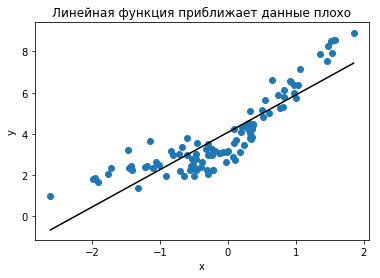

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
# генерируем данные
np.random.seed(42)
x = np.sort(np.random.normal(size=100))
y_expected = 3 + 0.5 * x + 3 * x * (x>0)
y = y_expected + np.random.normal(size=x.size, scale=0.5)
# оцениваем линейную регрессию
model = LinearRegression().fit(x[:, np.newaxis], y)
# рисуем
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
#plt.plot(x, y_expected, color = 'b')
plt.plot(x, model.predict(x[:, np.newaxis]), color='k')
#plt.legend(['true', 'predicted'])
plt.title('Линейная функция приближает данные плохо')
plt.show()

Такие функции часто встречаются в жизни. Например:
* временные ряды, в которых в какой-то момент изменился характер процесса
* функции издержек, когда начиная с какого-то объема производства нужно подключать более дорогие ресурсы
* свойства материала, который начиная с некоторый температуры меняет свою физическую структуру

Поскольку обычная линейная модель для оценки таких зависимостей не годится, соберём базис из кусочно-линейных функций, изломанных в разных местах (а именно, в различных квантилях независимой переменной). 

Первая функция в базисе - это тождественное преобразование $y=x$, а остальные выглядят как $y=max(0, x-a)$ с различными $a$.

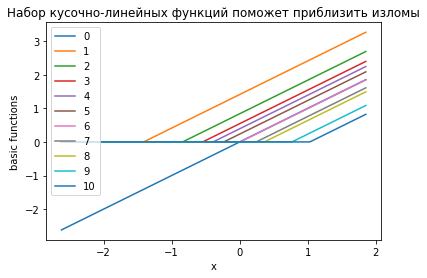

In [2]:
k = 10 # количество базисных функций
thresholds = np.percentile(x, np.linspace(0, 1, k+2)[1:-1]*100)
basis = np.hstack([x[:, np.newaxis],  np.maximum(0,  np.column_stack([x]*k)-thresholds)]) 

plt.plot(x, basis)
plt.legend(np.arange(k+1))
plt.xlabel('x')
plt.ylabel('basic functions')
plt.title('Набор кусочно-линейных функций поможет приблизить изломы')
plt.show()

Теперь на этот базис можно натравить лассо-регрессию. 

Если вкратце, это такая линейная регрессия, которая сама зануляет ненужные коэффициенты. Попозже я расскажу о ней отдельно. 

Так вот, лассо-регрессия оставила только три ненулевые коэффициента - первый, для левой половинки прямой, и два, рассчитывающие увеличение наклона для правой половинки. 

Излома получилось два, потому что я сгенерировал только 10 точек излома, и вместо одного точного попадания пришлось устроить два неточных. 

[ 0.53  0.    0.    0.    0.    1.4   1.14  0.    0.    0.    0.  ]


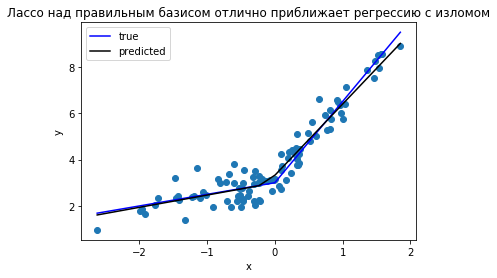

In [3]:
from sklearn.linear_model import Lasso
model = Lasso(0.03).fit(basis, y)
print(model.coef_.round(2))
plt.scatter(x, y)
plt.plot(x, y_expected, color = 'b')
plt.plot(x, model.predict(basis), color='k')
plt.legend(['true', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Лассо над правильным базисом отлично приближает регрессию с изломом')
plt.show()

Видим, что лассо весьма неплохо попадает в истинный тренд. Успех!

Но чем плоха обычная линейная регрессия, не-лассо?

Ответ простой: она не удаляет никаких коэффициентов, и вместо одного излома мы получаем $k$. Не то, чего мы хотели от жизни. 

Это, кстати, наглядный пример переподгонки (aka *переобучения*) модели!

[ 1.13 -0.49 -1.04  0.41  1.06 -0.12  3.06 -1.13  0.8  -1.29  0.99]


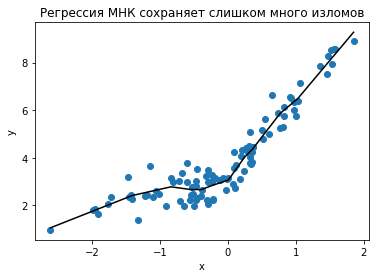

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(basis, y)
print(model.coef_.round(2))
plt.scatter(x, y)
plt.plot(x, model.predict(basis), color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Регрессия МНК сохраняет слишком много изломов')
plt.show()

Обычная линейная регрессия получает свои коэффициенты путём операций с матрицами: $y=(X^TX)^{-1}X^Ty$. 

А как находит свои коэффициенты лассо-регрессия? Половина секрета заключается в методе координатного спуска, [о котором я уже рассказывал](https://vk.com/wall-130785301_12).

До встречи!

[ 0.53  0.    0.    0.    0.    1.4   1.14  0.    0.    0.    0.  ]


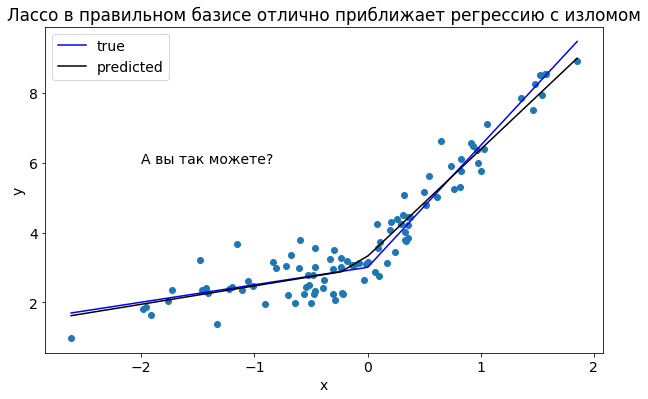

In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
model = Lasso(0.03).fit(basis, y)
print(model.coef_.round(2))
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x, y_expected, color = 'b')
plt.plot(x, model.predict(basis), color='k')
plt.legend(['true', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Лассо в правильном базисе отлично приближает регрессию с изломом')
plt.text(x=-2, y=6, s='А вы так можете?')
plt.show()